# Least-squares parameter estimation

The model structure used is the so-called ARX (Auto-Regressive with eXogenous input) model:
![ARX block diagram](arx-block.png "ARX model")
 where $u(k)$ is a known input signal, $y(k)$ is the output signal and $e(k)$ is a disturbance (an unknown input signal) in the form of a zero-mean white noise sequence.
 
 The model can be written
 \begin{align*}
  A(\text{q}) y(k) &= B(\text{q})u(k) + \text{q}^n e(k)\\
  (\text{q}^n + a_1\text{q}^{n-1} + \cdots + a_n)y(k) &= (b_0\text{q}^{m} + b_1\text{q}^{m-1} + \cdots + b_m)u(k) + \text{q}^n e(k)\\
  y(k+n) + a_1 y(k+n-1) + \cdots + a_n y(k) &= b_0u(k+m) + b_1u(k+m-1) + \cdots + b_m u(k) + e(k+n)\\
  y(k+1) + a_1y(k) + \cdots + a_n y(k-n+1) &= b_0 u(k+m-n+1) + b_1u(k+m-n) + \cdots + b_m u(k-n+1)) + e(k+1)
  \end{align*}
  The one-step-ahead predictor for this model becomes 
  \begin{align*}
  \hat{y}(k+1) &= -a_1 y(k) - a_2 y(k-1) - \cdots - a_n y(k-n+1) \\ &\qquad + b_0 u(k+m-n+1) + b_1 u(k+m-n) +  \cdots + b_m u(k-n+1)\\
               & = \underbrace{\begin{bmatrix} -y(k) & \cdots & -y(k-n+1) & u(k+m-n+1) & \cdots & u(k-n+1)\end{bmatrix}}_{\varphi^{T}(k+1)} \underbrace{\begin{bmatrix} a_1\\\vdots\\a_n\\b_0\\\vdots\\b_m\end{bmatrix}}_{\theta}\\
   &= \varphi^{T}(k+1)\theta.
  \end{align*}
  Note that the white noise term $e(k+1)$ by definition cannot be predicted from knowledge of previous values in the sequence (which we don't know) nor from previous output values $y(t), \; t \le k$ (which could have been used to estimate $\hat{e}(k)$). Therefore $e(k+1)$ is predicted by its mean value which is zero. Note also that if our model with $\theta = \theta^*$ is perfect ($\theta^*$ contains the true parameters for the system which generated the data), then the prediction error equals the white noise disturbance: $\epsilon(k+1) = y(k+1) - \varphi^{T}(k+1)\theta^* = e(k+1)$. Therefore, we can check how good a models is by testing how close the prediction errors resembles a white noise sequence.

  The system of equations in the unknown system parameters $\theta$ is
  $ \Phi \theta = y, $
  where
  \begin{align*}
  \Phi &= \begin{bmatrix} \varphi^{T}(n+1)\\\varphi^{T}(n+2)\\\vdots\\\varphi^{T}(N)\end{bmatrix},\\
  y &= \begin{bmatrix} y(n+1)\\y(n+2)\\\vdots\\y(N)\end{bmatrix}.
  \end{align*}

  The least-squares solution to this system of equations is, by definition, the solution $\hat{\theta}$ which minimizes the sum of squares of the residuals $\epsilon = y-\Phi\theta$, i.e. the solution that minimizes the criterion
  $ J(\theta) = \epsilon^{T}\epsilon = \sum_i \epsilon_i^2. $ 
  It is given by 
  $ \hat{\theta}_{LS} = \underbrace{(\Phi^{T}\Phi)^{-1}\Phi^{T}}_{\Phi^+} y, $
  where $\Phi^+$ is called the *Moore-Penrose invers* of the (typically) non-square, tall matrix $\Phi$. 



# Instructions
1. Download the data: __[http://alfkjartan.github.io/files/sysid_exercise_data.mat](http://alfkjartan.github.io/files/sysid_exercise_data.mat)__. The data consist of 12 vectors `u1`, `y1`, `u1_val`, `y1_val`, `u2`, `y2`, `u2_val`, `y2_val`, `u3`, `y3`, `u3_val`, `y3_val` corresponding to three different LTI systems.
     - `ui`  :: input data for system $i$ 
     - `yi` :: output data for system $i$ 
     - `ui_val` :: validation input data for system $i$ 
     - `yi_val` :: validation output data for system $i$
     The systems are 
     1. $ H_1(z) = \frac{b}{z+a} = \frac{0.2}{z -0.8} $
     2. $ H_2(z) = \frac{b_0 z + b_1}{z(z+a_1)} = \frac{0.0625z + 0.0375}{z(z - 0.9)} $
     3. $ H_3(z) = \frac{b}{z^2 + a_1z + a_2} = \frac{0.18}{z^2 - 1.4z + 0.58} $
2. For each case estimate a model using the input-output data. Formulate the one-step ahead predictor $ \hat{y}(k) = \varphi^T(k)\theta$ and the system of equations 
     $\Phi \theta = y$, and find the least-squares solution to the system. Compare with the true parameters.
3. Validate your model using the validation data. Let's say you have obtained estimates of the numerator $\hat{B}(z)$ and denominator $\hat{A}(z)$ of your model. You can then simulate the model using the validation data (a data set which is **not** used for parameter estimation)


In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import control

## Load the data

In [3]:
!wget http://alfkjartan.github.io/files/sysid_exercise_data.mat
data = sio.loadmat("sysid_exercise_data.mat")

--2019-10-03 13:52:24--  http://alfkjartan.github.io/files/sysid_exercise_data.mat
Resolving alfkjartan.github.io (alfkjartan.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to alfkjartan.github.io (alfkjartan.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10576 (10K) [application/octet-stream]
Saving to: ‘sysid_exercise_data.mat.5’

sysid_exercise_data 100%[===================>]  10.33K  --.-KB/s    in 0s      

2019-10-03 13:52:25 (136 MB/s) - ‘sysid_exercise_data.mat.5’ saved [10576/10576]



## Plot the data for system 1

200

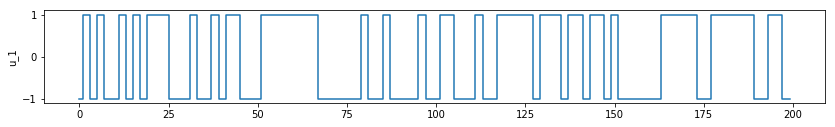

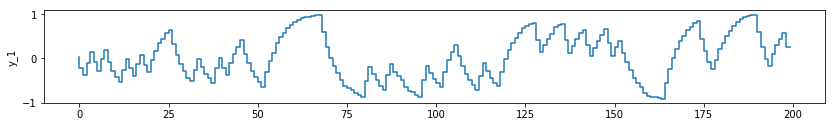

In [4]:
N = len(data["u1"])
plt.figure(figsize=(14,1.7))
plt.step(range(N),data["u1"])
plt.ylabel("u_1")
plt.figure(figsize=(14,1.7))
plt.step(range(N),data["y1"])
plt.ylabel("y_1")
data["u1"].size

## Identify first order model for system 1
Consider the model structure 
$$y(k) = \frac{b_0\text{q}+b_1}{\text{q}+a} \text{q}^{-1} u(k),$$
which is a first order model with one zero, one pole and one delay. The true system has $b_0=0.2$, $b_1=0$ and $a=-0.8$.

The ARX model can be written 
$$ y(k+1) = -ay(k) + b_0u(k) + b_1u(k-1) + e(k+1),$$
and so the one-step-ahead predictor becomes
$$ \hat{y}(k+1) = -ay(k) + b_0u(k) + b_1u(k-1) = \begin{bmatrix} -y(k) & u(k) & u(k-1) \end{bmatrix}\begin{bmatrix} a\\b_0\\b_1 \end{bmatrix}. $$

The systems of equations becomes
$$ \underbrace{\begin{bmatrix} -y(2) & u(2) & u(1)\\-y(3) & u(3) & u(2)\\ \vdots & \vdots & \vdots\\ -y(N-1) & u(N-1) & u(N-2) \end{bmatrix}}_{\Phi} \underbrace{\begin{bmatrix} a\\b_0\\b_1\\\end{bmatrix}}_{\theta} =
\begin{bmatrix} y(3)\\y(4)\\\vdots\\y(N) \end{bmatrix},$$
which is solved using least squares.

In [6]:
y = data["y1"]
u = data["u1"]
Phi = np.array([-np.ravel(y[1:N-1]), 
                np.ravel(u[1:N-1]), 
                np.ravel(u[:N-2])]).T
yy = y[2:]
theta_ls = np.linalg.lstsq(Phi, yy)
theta_ls
print("Estimated: a = %f" % theta_ls[0][0])
print("Estimated: b_0 = %f" % theta_ls[0][1])
print("Estimated: b_1 = %f" % theta_ls[0][2])


Estimated: a = -0.805740
Estimated: b_0 = 0.202142
Estimated: b_1 = 0.000280


## Validation
The validation is always done one input-output data that were **not** used in the parameter estimation. It is also recommended to use a k-step-ahead predictor. See section about validation further down.

Order n=2
Data points N=200


Text(0.5,1,'RMSE = 0.033556')

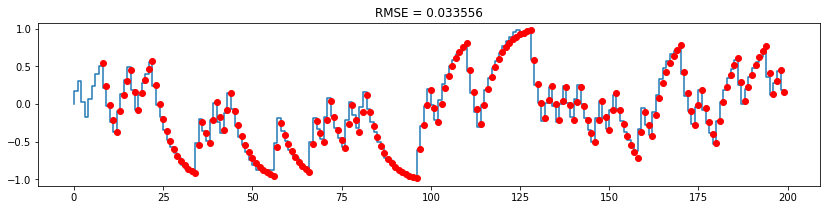

In [16]:
# Import the predict_lti function which will calculate the k-step ahead prediction.
from lti_fcns import predict_lti
yv = np.ravel(data["y1_val"])
uv = np.ravel(data["u1_val"])
k = 8 # The prediction horizon
d = 1 # The input delay of the system
a = np.array([1, theta_ls[0][0]])
b = np.ravel(theta_ls[0][1:])
(ypred, tpred) = predict_lti(b,a,yv, uv, k, d)
N = len(uv)
plt.figure(figsize=(14,3))
plt.step(range(N), yv)
plt.plot(tpred, ypred, 'ro')

# Calculate the Root Mean Square Error (RMSE)
err = yv[tpred[0]:] - ypred
RMSE = np.sqrt(1.0/N * np.sum( np.square(yv[tpred[0]:] - ypred)))
plt.title("RMSE = %f" %RMSE)

## Do the other systems on  your own :-)